# Etapa de pre-processamento dos dados

In [2]:
import pandas as pd

df = pd.read_csv('trajectories_to_publish.csv');

df.head();


In [3]:
#Verificando valores nulos

print(df.isnull().sum())

#Convertendo a coluna 'time' para datetime

df['timestamp'] = pd.to_datetime(df['timestamp'])

#Verificando o tipo de dados

trip_id                   0
timestamp                 0
velocity_kmh            694
acceleration_mss    2027054
latitude                648
longitude               648
bearing                 648
dtype: int64


In [4]:
# Preencher aceleração faltante onde a velocidade é zero
df.loc[(df['velocity_kmh'] == 0) & (df['acceleration_mss'].isnull()), 'acceleration_mss'] = 0
#Preenchendo valores faltantes de latitude e longitude quando a velocidade é zero
mask = (df['velocity_kmh'] == 0) & (df['latitude'].isnull()) & (df['longitude'].isnull())
df.loc[mask, ['latitude', 'longitude']] = df.loc[mask, ['latitude', 'longitude']].fillna(method='ffill')
#Preencher os valores faltantes do bearing com o ultimo valor conhecido quando a velocidade é zero
df.loc[(df['velocity_kmh'] == 0) & (df['bearing'].isnull()), 'bearing'] = df['bearing'].ffill()

# Verificar valores faltantes restantes
print(df.isnull().sum())

C:\Users\danie\AppData\Local\Temp\ipykernel_16172\3728776042.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[mask, ['latitude', 'longitude']] = df.loc[mask, ['latitude', 'longitude']].fillna(method='ffill')


trip_id                 0
timestamp               0
velocity_kmh          694
acceleration_mss    94424
latitude              648
longitude             648
bearing               492
dtype: int64


In [5]:
#Excluindo valores faltantes
df.dropna(inplace=True)

#Verificando valores faltantes
print(df.isnull().sum())

trip_id             0
timestamp           0
velocity_kmh        0
acceleration_mss    0
latitude            0
longitude           0
bearing             0
dtype: int64


In [6]:
# Função para calcular a distância entre dois pontos utilizando a fórmula de Haversine
import numpy as np
def haversine(lat1, lon1, lat2, lon2):
    # Converter de graus para radianos
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Diferenças
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Fórmula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Raio médio da Terra em quilômetros
    return c * r

In [7]:
# Calcular a diferença de tempo em segundos
df['time_diff'] = df.groupby('trip_id')['timestamp'].diff().dt.total_seconds()
df['time_diff'] = df['time_diff'].fillna(0)

# Calcular a distância entre pontos consecutivos
df['lat_shift'] = df.groupby('trip_id')['latitude'].shift()
df['lon_shift'] = df.groupby('trip_id')['longitude'].shift()

df['segment_distance'] = haversine(
    df['latitude'], df['longitude'],
    df['lat_shift'], df['lon_shift']
)

df['segment_distance'] = df['segment_distance'].fillna(0)

# Calcular a velocidade calculada (opcional, para validação)
df['calculated_speed'] = (df['segment_distance'] / (df['time_diff'] / 3600)).replace([np.inf, -np.inf], 0)

# Calcular mudanças no bearing
df['bearing_shift'] = df.groupby('trip_id')['bearing'].shift()
df['bearing_change'] = (df['bearing'] - df['bearing_shift']).fillna(0).abs()

# Criar máscaras para aceleração positiva e negativa
acc_positive_mask = df['acceleration_mss'] > 0
acc_negative_mask = df['acceleration_mss'] < 0

# Função personalizada para agregação
def agg_by_condition(group, mask, stats=['mean', 'max', 'min', 'std']):
    """Calcula estatísticas apenas para valores que atendem à condição da máscara"""
    return group[mask].agg(stats)

# Calcular métricas por viagem
trip_stats = pd.concat([
    # Métricas de velocidade
    df.groupby('trip_id')['velocity_kmh'].agg(['mean', 'max', 'min', 'std']).add_prefix('velocity_kmh_'),
    
    # Métricas de aceleração positiva (aceleração)
    df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'], 
                                                          x['acceleration_mss'] > 0)
                              ).add_prefix('acceleration_positive_'),
    
    # Métricas de aceleração negativa (frenagem)
    df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'], 
                                                          x['acceleration_mss'] < 0)
                              ).add_prefix('acceleration_negative_'),
    
    # Outras métricas
    df.groupby('trip_id').agg({
        'segment_distance': 'sum',
        'time_diff': 'sum',
        'bearing_change': 'sum',
        'calculated_speed': 'mean',
        'trip_id': 'count'
    }),
    
    # Timestamps
    df.groupby('trip_id')['timestamp'].agg(['min', 'max'])
    
], axis=1)

# Adicionar contagem de eventos de aceleração/frenagem
trip_stats['acceleration_events_count'] = df[acc_positive_mask].groupby('trip_id').size()
trip_stats['braking_events_count'] = df[acc_negative_mask].groupby('trip_id').size()

# Calcular tempo total da viagem em minutos
trip_stats['trip_duration_min'] = trip_stats['time_diff'] / 60

# Calcular velocidade média geral da viagem
trip_stats['overall_avg_speed'] = (trip_stats['segment_distance'] / (trip_stats['time_diff'] / 3600)).replace([np.inf, -np.inf], 0)

# Preencher NaN com 0 para viagens que não têm eventos de aceleração ou frenagem
trip_stats = trip_stats.fillna(0)

# Exibir as primeiras linhas e as colunas disponíveis
print("Colunas disponíveis:")
print(trip_stats.columns.tolist())
print("\nPrimeiras linhas dos dados:")
print(trip_stats.head())

C:\Users\danie\AppData\Local\Temp\ipykernel_16172\4203863138.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'],
C:\Users\danie\AppData\Local\Temp\ipykernel_16172\4203863138.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'],


Colunas disponíveis:
['velocity_kmh_mean', 'velocity_kmh_max', 'velocity_kmh_min', 'velocity_kmh_std', 'acceleration_positive_mean', 'acceleration_positive_max', 'acceleration_positive_min', 'acceleration_positive_std', 'acceleration_negative_mean', 'acceleration_negative_max', 'acceleration_negative_min', 'acceleration_negative_std', 'segment_distance', 'time_diff', 'bearing_change', 'calculated_speed', 'trip_id', 'min', 'max', 'acceleration_events_count', 'braking_events_count', 'trip_duration_min', 'overall_avg_speed']

Primeiras linhas dos dados:
         velocity_kmh_mean  velocity_kmh_max  velocity_kmh_min  \
trip_id                                                          
T-1              49.794948             103.0               0.0   
T-10             76.772414             112.0               0.0   
T-100            29.084164              85.0               0.0   
T-1000           97.015910             134.0               0.0   
T-10000          93.366492             122.0   

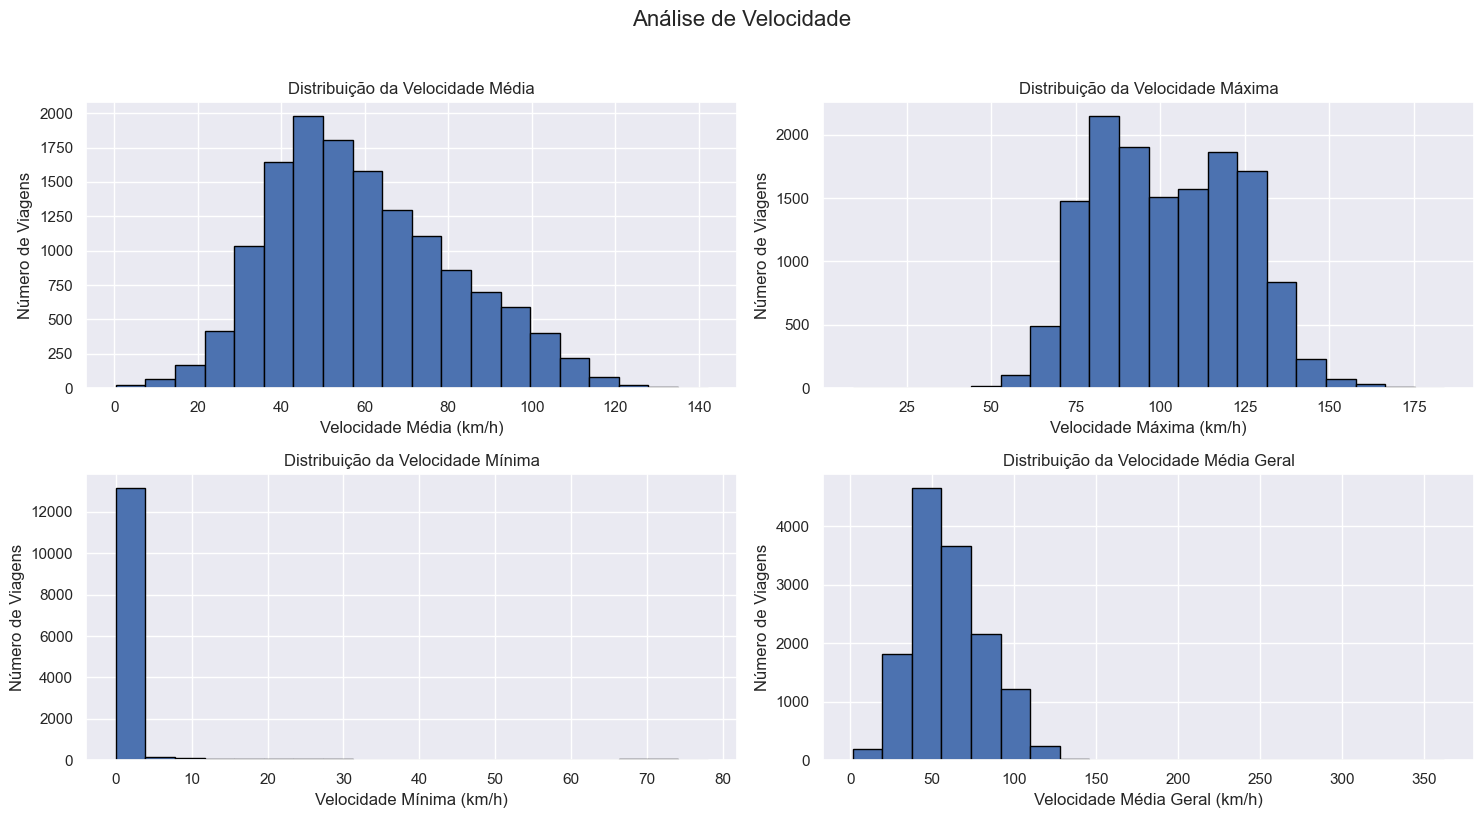

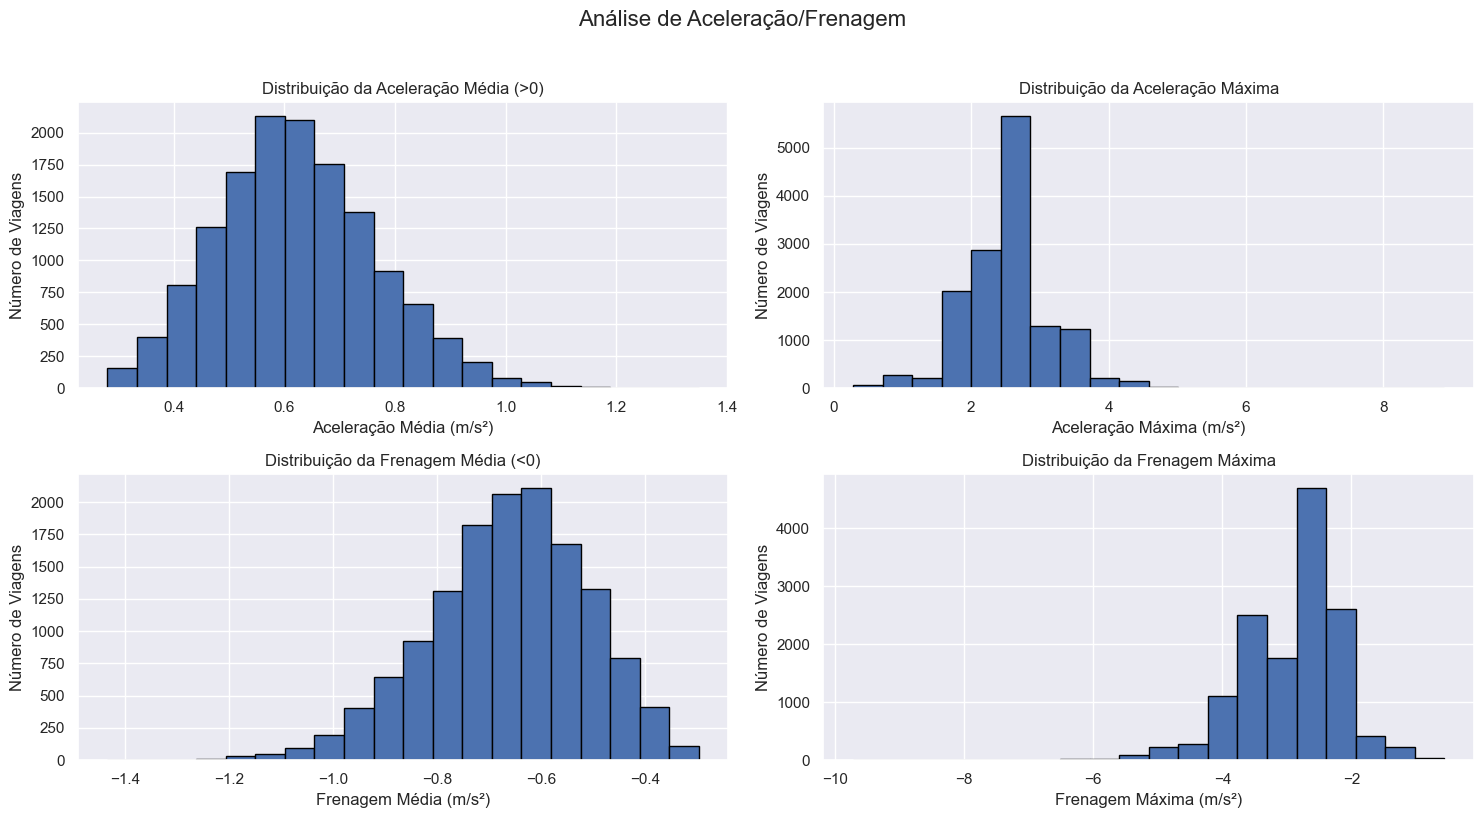

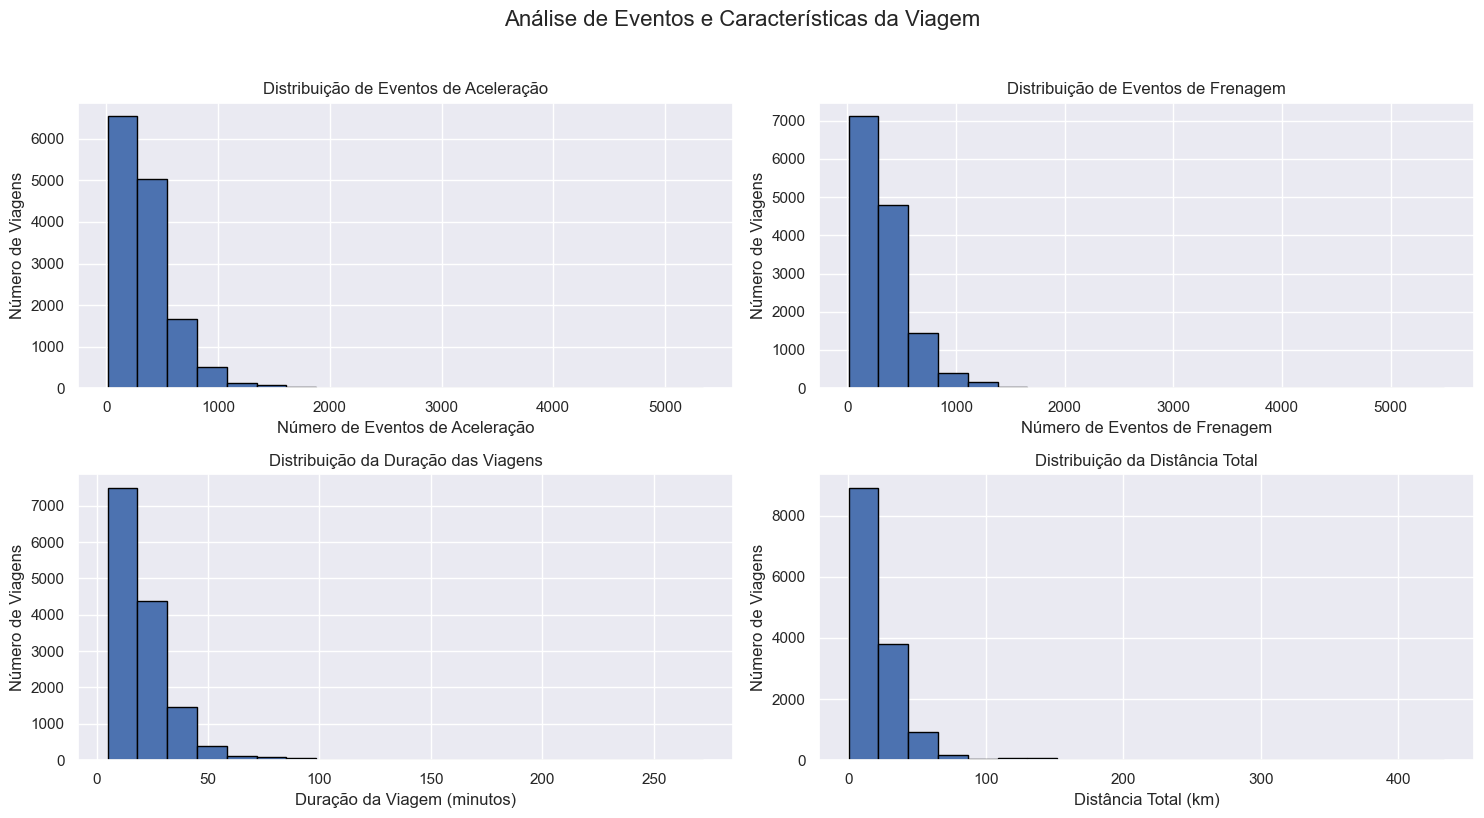

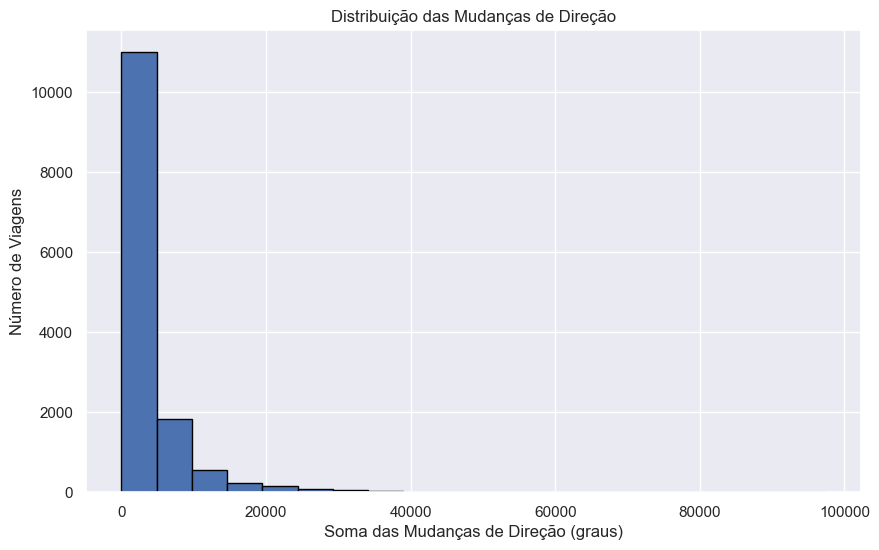

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para melhor visualização
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]

# 1. Métricas de Velocidade
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Análise de Velocidade', fontsize=16, y=1.02)

axes[0,0].hist(trip_stats['velocity_kmh_mean'], bins=20, edgecolor='black')
axes[0,0].set_xlabel('Velocidade Média (km/h)')
axes[0,0].set_ylabel('Número de Viagens')
axes[0,0].set_title('Distribuição da Velocidade Média')

axes[0,1].hist(trip_stats['velocity_kmh_max'], bins=20, edgecolor='black')
axes[0,1].set_xlabel('Velocidade Máxima (km/h)')
axes[0,1].set_ylabel('Número de Viagens')
axes[0,1].set_title('Distribuição da Velocidade Máxima')

axes[1,0].hist(trip_stats['velocity_kmh_min'], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Velocidade Mínima (km/h)')
axes[1,0].set_ylabel('Número de Viagens')
axes[1,0].set_title('Distribuição da Velocidade Mínima')

axes[1,1].hist(trip_stats['overall_avg_speed'], bins=20, edgecolor='black')
axes[1,1].set_xlabel('Velocidade Média Geral (km/h)')
axes[1,1].set_ylabel('Número de Viagens')
axes[1,1].set_title('Distribuição da Velocidade Média Geral')

plt.tight_layout()
plt.show()

# 2. Métricas de Aceleração
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Análise de Aceleração/Frenagem', fontsize=16, y=1.02)

axes[0,0].hist(trip_stats['acceleration_positive_mean'], bins=20, edgecolor='black')
axes[0,0].set_xlabel('Aceleração Média (m/s²)')
axes[0,0].set_ylabel('Número de Viagens')
axes[0,0].set_title('Distribuição da Aceleração Média (>0)')

axes[0,1].hist(trip_stats['acceleration_positive_max'], bins=20, edgecolor='black')
axes[0,1].set_xlabel('Aceleração Máxima (m/s²)')
axes[0,1].set_ylabel('Número de Viagens')
axes[0,1].set_title('Distribuição da Aceleração Máxima')

axes[1,0].hist(trip_stats['acceleration_negative_mean'], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Frenagem Média (m/s²)')
axes[1,0].set_ylabel('Número de Viagens')
axes[1,0].set_title('Distribuição da Frenagem Média (<0)')

axes[1,1].hist(trip_stats['acceleration_negative_min'], bins=20, edgecolor='black')
axes[1,1].set_xlabel('Frenagem Máxima (m/s²)')
axes[1,1].set_ylabel('Número de Viagens')
axes[1,1].set_title('Distribuição da Frenagem Máxima')

plt.tight_layout()
plt.show()

# 3. Métricas de Eventos
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Análise de Eventos e Características da Viagem', fontsize=16, y=1.02)

axes[0,0].hist(trip_stats['acceleration_events_count'], bins=20, edgecolor='black')
axes[0,0].set_xlabel('Número de Eventos de Aceleração')
axes[0,0].set_ylabel('Número de Viagens')
axes[0,0].set_title('Distribuição de Eventos de Aceleração')

axes[0,1].hist(trip_stats['braking_events_count'], bins=20, edgecolor='black')
axes[0,1].set_xlabel('Número de Eventos de Frenagem')
axes[0,1].set_ylabel('Número de Viagens')
axes[0,1].set_title('Distribuição de Eventos de Frenagem')

axes[1,0].hist(trip_stats['trip_duration_min'], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Duração da Viagem (minutos)')
axes[1,0].set_ylabel('Número de Viagens')
axes[1,0].set_title('Distribuição da Duração das Viagens')

axes[1,1].hist(trip_stats['segment_distance'], bins=20, edgecolor='black')
axes[1,1].set_xlabel('Distância Total (km)')
axes[1,1].set_ylabel('Número de Viagens')
axes[1,1].set_title('Distribuição da Distância Total')

plt.tight_layout()
plt.show()

# 4. Mudanças de Direção
plt.figure(figsize=(10, 6))
plt.hist(trip_stats['bearing_change'], bins=20, edgecolor='black')
plt.xlabel('Soma das Mudanças de Direção (graus)')
plt.ylabel('Número de Viagens')
plt.title('Distribuição das Mudanças de Direção')
plt.show()

# Etapa de treinamento de modelos ML


Cluster 0 características:
velocity_kmh_mean              82.810652
velocity_kmh_max              126.301234
acceleration_positive_mean      0.522946
acceleration_positive_max       2.545425
acceleration_positive_min       0.309235
acceleration_negative_mean     -0.558256
acceleration_negative_max      -0.309235
acceleration_negative_min      -3.124558
segment_distance               50.423479
trip_duration_min              36.566707
Name: 0, dtype: float64
Número de viagens: 1483

Cluster 1 características:
velocity_kmh_mean             51.290199
velocity_kmh_max              90.390677
acceleration_positive_mean     0.601215
acceleration_positive_max      2.328627
acceleration_positive_min      0.267521
acceleration_negative_mean    -0.637915
acceleration_negative_max     -0.267521
acceleration_negative_min     -2.562965
segment_distance               5.752341
trip_duration_min             10.434175
Name: 1, dtype: float64
Número de viagens: 2741

Cluster 2 características:
velocity_k

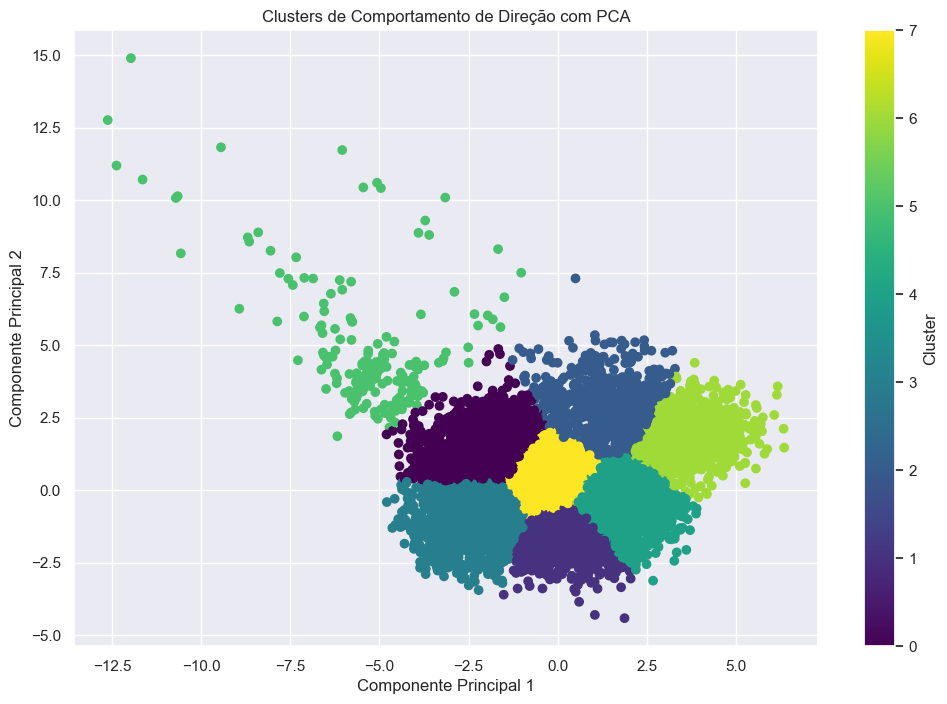


Random Forest Performance:
Training accuracy: 1.000
Testing accuracy: 0.935


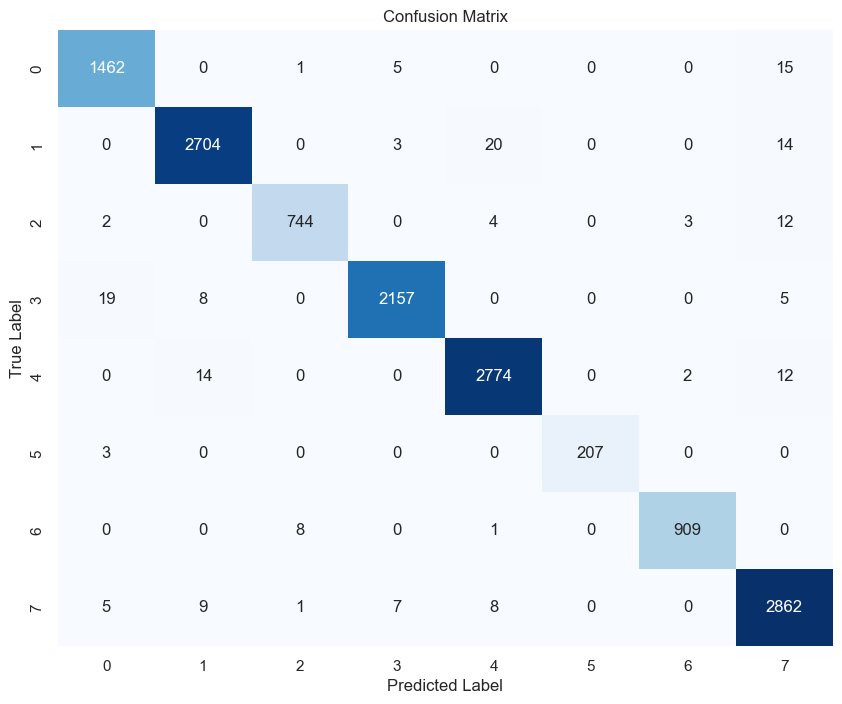

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Preparar features para clustering
features_for_clustering = [
    'velocity_kmh_mean', 'velocity_kmh_max', 'acceleration_positive_mean', 'acceleration_positive_max', 'acceleration_positive_min',
    'acceleration_negative_mean', 'acceleration_negative_max', 'acceleration_negative_min', 
    'segment_distance', 'trip_duration_min'
]

# Normalizar os dados
X = trip_stats[features_for_clustering].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Aplicar K-means nos dados transformados pelo PCA
n_clusters = 8  # Você pode ajustar este número
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
trip_stats['driving_style'] = kmeans.fit_predict(X_pca)

# Transformar os centróides de volta para o espaço original
centroids_pca = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(pca.inverse_transform(centroids_pca))

# Criar DataFrame com os centróides no espaço original
centroids_df = pd.DataFrame(centroids_original, columns=features_for_clustering)

c_clusters_export = {}

# Imprimir características de cada cluster
for i in range(n_clusters):
    print(f"\nCluster {i} características:")
    print(centroids_df.iloc[i])
    print(f"Número de viagens: {(trip_stats['driving_style'] == i).sum()}")
    # Armazenar as características dos clusters com os nomes das características
    c_clusters_export[f"Cluster_{i}"] = centroids_df.iloc[i]

    


# Preparar dados para classificação
X = trip_stats[features_for_clustering]
y = trip_stats['driving_style']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Treinar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
rf_model.fit(X_train, y_train)

# Avaliar o modelo
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print("\nRandom Forest Performance:")
print(f"Training accuracy: {train_score:.3f}")
print(f"Testing accuracy: {test_score:.3f}")

# Analisar importância das features
feature_importance = pd.DataFrame({
    'feature': features_for_clustering,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualizar clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1], 
    c=trip_stats['driving_style'], 
    cmap='viridis'
)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters de Comportamento de Direção com PCA')
plt.colorbar(label='Cluster')
plt.show()

#Matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prever os clusters
y_pred = rf_model.predict(X)

# Criar a matriz de confusão
conf_matrix = confusion_matrix(y, y_pred)

print("\nRandom Forest Performance:")
print(f"Training accuracy: {train_score:.3f}")
print(f"Testing accuracy: {test_score:.3f}")

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



C:\Users\danie\AppData\Local\Temp\ipykernel_16172\2402763343.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='driving_style', y='braking_events_count', data=trip_stats, ci=None, estimator=sum, palette='viridis')
C:\Users\danie\AppData\Local\Temp\ipykernel_16172\2402763343.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='driving_style', y='braking_events_count', data=trip_stats, ci=None, estimator=sum, palette='viridis')


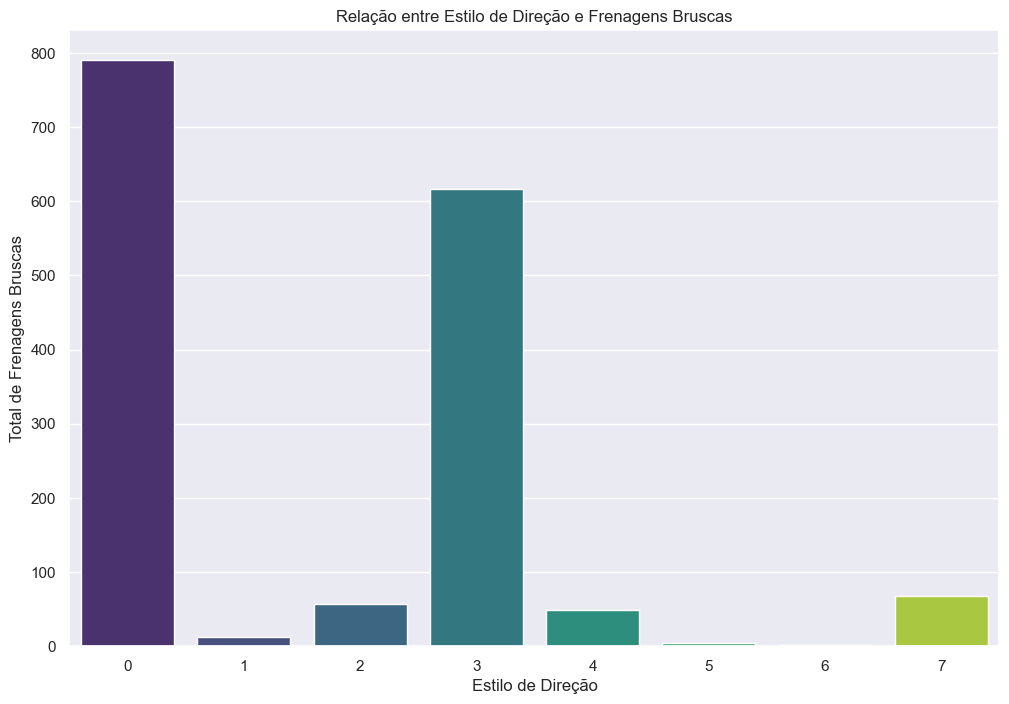

Métricas no conjunto de treino:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10377
           1       1.00      1.00      1.00       823

    accuracy                           1.00     11200
   macro avg       1.00      1.00      1.00     11200
weighted avg       1.00      1.00      1.00     11200


Métricas no conjunto de teste:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2567
           1       0.65      0.05      0.09       233

    accuracy                           0.92      2800
   macro avg       0.78      0.52      0.52      2800
weighted avg       0.90      0.92      0.89      2800



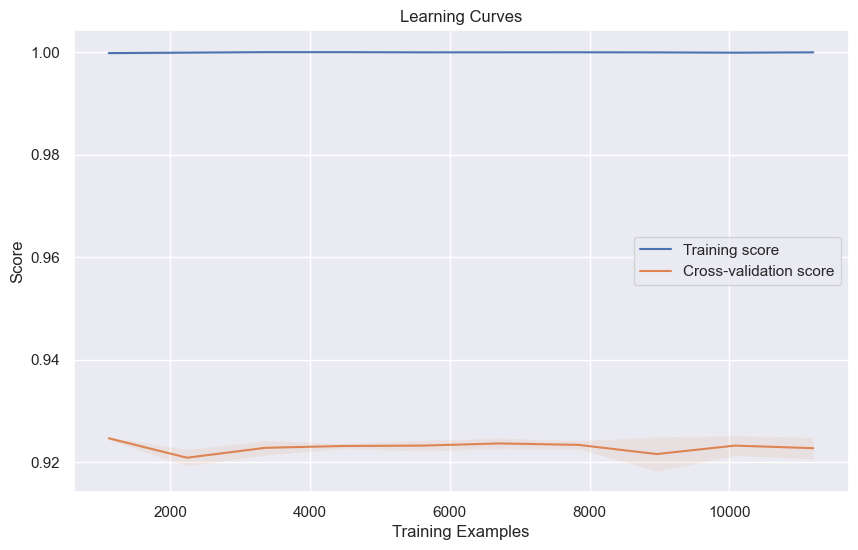

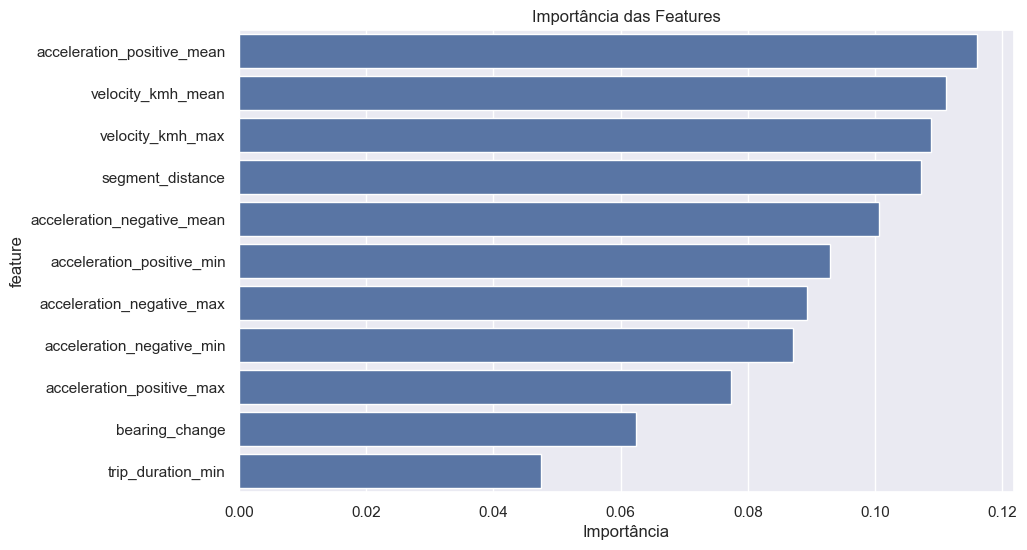


Melhores parâmetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Métricas do modelo otimizado no conjunto de teste:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2567
           1       0.94      0.06      0.12       233

    accuracy                           0.92      2800
   macro avg       0.93      0.53      0.54      2800
weighted avg       0.92      0.92      0.89      2800



In [ ]:
#Indentificando quantidade de freagens bruscas por trip_id
#Considerando a aceleração de -4 m/s² uma frenagem brusca
df['braking'] = df['acceleration_mss'] < -4
df['braking'] = df['braking'].astype(int)
braking_count = df.groupby('trip_id')['braking'].sum()

#Relacionando a quantidade de frenagens bruscas com o comportamento de direção
trip_stats['braking_events_count'] = braking_count
trip_stats['braking_events_count'] = trip_stats['braking_events_count'].fillna(0)

# Criar variável alvo binária: 1 se houver pelo menos uma frenagem brusca, caso contrário 0
trip_stats['has_braking_event'] = trip_stats['braking_events_count'].apply(lambda x: 1 if x > 0 else 0)

#Visualizando a relação entre a quantidade de frenagens bruscas e o comportamento de direção
plt.figure(figsize=(12, 8))
sns.barplot(x='driving_style', y='braking_events_count', data=trip_stats, ci=None, estimator=sum, palette='viridis')
plt.xlabel('Estilo de Direção')
plt.ylabel('Total de Frenagens Bruscas')
plt.title('Relação entre Estilo de Direção e Frenagens Bruscas')
plt.show()

#Prevendo a chance de ocorrer uma frenagem brusca em uma viagem
# Preparar features para classificação
features_for_classification = [
    'velocity_kmh_mean', 'velocity_kmh_max', 'acceleration_positive_mean', 'acceleration_positive_max', 'acceleration_positive_min',
    'bearing_change', 'segment_distance', 'trip_duration_min'
]

# Normalizar os dados
X = trip_stats[features_for_classification].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, trip_stats['has_braking_event'], test_size=0.2, random_state=42
)

# Treinar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
rf_model.fit(X_train, y_train)

# Realizar predições
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Calcular métricas de avaliação para treino e teste
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("Métricas no conjunto de treino:")
print(classification_report(y_train, y_pred_train))
print("\nMétricas no conjunto de teste:")
print(classification_report(y_test, y_pred_test))

# Visualizar curvas de aprendizado para detectar overfitting
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plotar curvas de aprendizado
plot_learning_curves(rf_model, X_scaled, trip_stats['has_braking_event'])


plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.show()

# Ajustar hiperparâmetros para reduzir overfitting se necessário
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_scaled, trip_stats['has_braking_event'])

print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# Criar modelo otimizado com os melhores parâmetros
best_rf_model = grid_search.best_estimator_

# Avaliar modelo otimizado
y_pred_best = best_rf_model.predict(X_test)
print("\nMétricas do modelo otimizado no conjunto de teste:")
print(classification_report(y_test, y_pred_best))






